<a href="https://colab.research.google.com/github/vamsigp/EIP-4/blob/master/wk-5/trail-2/W5_PersonAttributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
import numpy as np

from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

import os

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

In [0]:
one_hot_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg,resized/6.jpg,resized/7.jpg,resized/8.jpg,resized/9.jpg,resized/10.jpg
gender_female,0,1,0,0,1,0,0,0,0,0
gender_male,1,0,1,1,0,1,1,1,1,1
imagequality_Average,1,1,0,0,0,0,0,0,1,1
imagequality_Bad,0,0,0,0,0,0,1,0,0,0
imagequality_Good,0,0,1,1,1,1,0,1,0,0
age_15-25,0,0,0,0,0,0,0,0,0,0
age_25-35,0,0,0,0,0,0,1,1,0,1
age_35-45,1,1,0,0,1,1,0,0,1,0
age_45-55,0,0,1,1,0,0,0,0,0,0


In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
col_list = [_gender_cols_, _imagequality_cols_, _age_cols_, _weight_cols_, _carryingbag_cols_, _footwear_cols_, _emotion_cols_, _bodypose_cols_]

In [0]:
for row in (col_list):
  print(row)

['gender_female', 'gender_male']
['imagequality_Average', 'imagequality_Bad', 'imagequality_Good']
['age_15-25', 'age_25-35', 'age_35-45', 'age_45-55', 'age_55+']
['weight_normal-healthy', 'weight_over-weight', 'weight_slightly-overweight', 'weight_underweight']
['carryingbag_Daily/Office/Work Bag', 'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None']
['footwear_CantSee', 'footwear_Fancy', 'footwear_Normal']
['emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral', 'emotion_Sad']
['bodypose_Back', 'bodypose_Front-Frontish', 'bodypose_Side']


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Data generator
* Can use Image Augmentation (CutOut) for the Training Images
* Image Augmentation should not be used for Validation Images

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    image_aug = False

    def __init__(self, df, batch_size=32, shuffle=True, image_aug=False):
        self.image_aug = image_aug
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        
        if self.image_aug:
          eraser = get_random_eraser()
          aug_image_stack = np.stack([eraser(img) for img in image])

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        if self.image_aug:
          return aug_image_stack, target

        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
13271,resized/13273.jpg,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1
8514,resized/8515.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
11236,resized/11238.jpg,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1
9396,resized/9397.jpg,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1
9497,resized/9498.jpg,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11537 entries, 13271 to 3828
Data columns (total 28 columns):
image_path                              11537 non-null object
gender_female                           11537 non-null uint8
gender_male                             11537 non-null uint8
imagequality_Average                    11537 non-null uint8
imagequality_Bad                        11537 non-null uint8
imagequality_Good                       11537 non-null uint8
age_15-25                               11537 non-null uint8
age_25-35                               11537 non-null uint8
age_35-45                               11537 non-null uint8
age_45-55                               11537 non-null uint8
age_55+                                 11537 non-null uint8
weight_normal-healthy                   11537 non-null uint8
weight_over-weight                      11537 non-null uint8
weight_slightly-overweight              11537 non-null uint8
weight_underweight               

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, image_aug=True)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False, image_aug=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
# plt.imshow(images[0])
for key in targets.keys():
  targets.get('key')

In [0]:
targets.get('gender_output')[0]

array([0, 1], dtype=uint8)

#### Training Data Visualization

In [0]:
import matplotlib.pyplot as plt

plt.clf()
plt.style.use('seaborn-muted')

<Figure size 432x288 with 0 Axes>

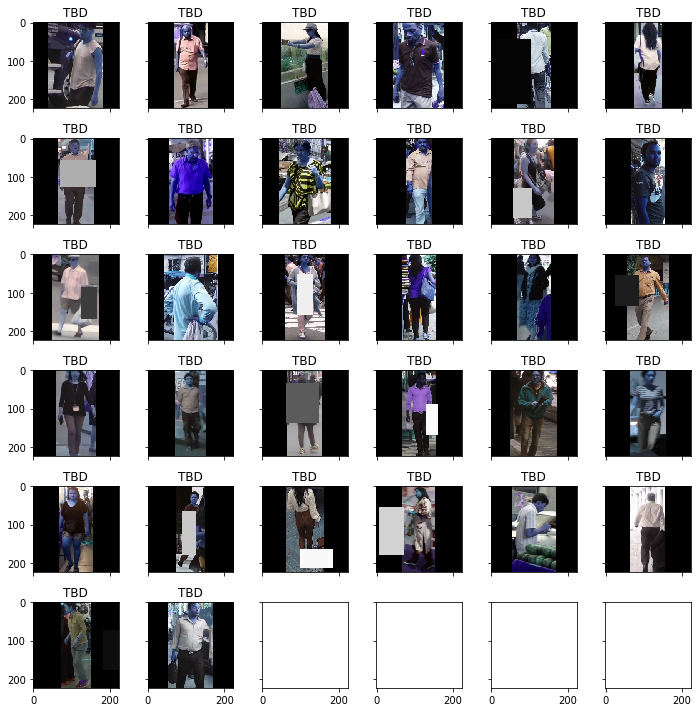

In [0]:
fig, axes = plt.subplots(6,6, figsize=(10,10),sharex=True, sharey=True, subplot_kw=dict(adjustable='box', aspect='equal'))

for i in range(len(images)):
  subplot_row = i//6
  subplot_col = i%6 
  ax = axes[subplot_row, subplot_col]
  ax.imshow(images[i], cmap='gray_r')
  ax.set_title('TBD')

plt.tight_layout()
plt.show()

### Model Creation - VGG16

In [0]:
# backbone = VGG16(
#     weights="imagenet", 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )

backbone = VGG16(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)
#vk
neck = BatchNormalization()(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization()(neck) #vk
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization()(neck) #vk
    return neck


def build_head(name, in_layer):
    x = Dense(num_units[name], activation="softmax", name=f"{name}_output")(in_layer)
    return x

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Training from scratch, so need to train all the layers of VGG-16

In [0]:
# freeze backbone
# VK
# for layer in backbone.layers:
# 	layer.trainable = False

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def update_callbacks():

  # Prepare model model saving directory.
  # save_dir = os.path.join(os.getcwd(), 'saved_models')
  save_dir = F"/content/gdrive/My Drive/saved_models" 
  model_name = 'Wk5_model.{epoch:03d}.{val_acc:.4f}.h5'
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)

  # Prepare callbacks for model saving and for learning rate adjustment.
  checkpoint = ModelCheckpoint(filepath=filepath,
                              monitor='val_acc',
                              verbose=1,
                              save_best_only=True)

  lr_scheduler = LearningRateScheduler(lr_schedule)

  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                cooldown=0,
                                patience=5,
                                min_lr=0.5e-6)

  #callbacks = [checkpoint, lr_reducer, lr_scheduler]
  # VK - check usage of other callbacks
  callbacks = [lr_reducer,lr_scheduler]

  return callbacks

In [0]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output_acc": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy"
}
loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [0]:
train_history = model.fit_generator(generator=train_gen, validation_data=valid_gen, 
                                    use_multiprocessing=True,
                                    callbacks = update_callbacks(),
                                    workers=8, epochs=50,verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





Learning rate:  0.001
360/360 [==============================] - 115s 318ms/step - loss: 8.9704 - gender_output_loss: 0.7484 - image_quality_output_loss: 1.0989 - age_output_loss: 1.6090 - weight_output_loss: 1.1893 - bag_output_loss: 1.0502 - footwear_output_loss: 1.0989 - pose_output_loss: 1.0576 - emotion_output_loss: 1.1180 - gender_output_acc: 0.5402 - image_quality_output_acc: 0.4843 - age_output_acc: 0.3195 - weight_output_acc: 0.5434 - bag_output_acc: 0.4838 - footwear_output_acc: 0.4795 - pose_output_acc: 0.5319 - emotion_output_acc: 0.6115 - val_loss: 8.0963 - val_gender_output_loss: 0.6805 - val_image_quality_output_loss: 1.0469 - val_age_output_loss: 1.4393 - val_weight_output_loss: 1.0232 - val_bag_output_loss: 0.9328 - val_footwear_output_loss: 1.0199 - val_pose_output_loss: 0.9961 - val_emotion_output_loss: 0.9577 - val_gender_output_acc: 0.5549 - val_image_qu

#### Model evalluation

In [0]:
results = model.evaluate_generator(valid_gen, verbose=1)

31/31 [==============================] - 5s 172ms/step


In [0]:
dict(zip(model.metrics_names, results))

{'age_output_acc': 0.39314516129032256,
 'age_output_loss': 1.4105250758509482,
 'bag_output_acc': 0.5640120967741935,
 'bag_output_loss': 0.9161673168982228,
 'emotion_output_acc': 0.7167338709677419,
 'emotion_output_loss': 0.8899683490876229,
 'footwear_output_acc': 0.5720766129032258,
 'footwear_output_loss': 0.9228323813407652,
 'gender_output_acc': 0.6063508064516129,
 'gender_output_loss': 0.6558459247312238,
 'image_quality_output_acc': 0.5367943548387096,
 'image_quality_output_loss': 0.9473255776589916,
 'loss': 7.627897585591962,
 'pose_output_acc': 0.6234879032258065,
 'pose_output_loss': 0.9095932629800612,
 'weight_output_acc': 0.6335685483870968,
 'weight_output_loss': 0.9756397585715016}

#### Model Accuracy

In [0]:
filtered_dict = {k:v for (k,v) in train_history.history.items() if "_acc" in k}
# filtered_dict

In [0]:
filtered_dict.keys()

dict_keys(['val_gender_output_acc', 'val_image_quality_output_acc', 'val_age_output_acc', 'val_weight_output_acc', 'val_bag_output_acc', 'val_footwear_output_acc', 'val_pose_output_acc', 'val_emotion_output_acc', 'gender_output_acc', 'image_quality_output_acc', 'age_output_acc', 'weight_output_acc', 'bag_output_acc', 'footwear_output_acc', 'pose_output_acc', 'emotion_output_acc'])

In [0]:
max_acc_dict = {}
for key in filtered_dict.keys():
  max_acc_dict[key] = max(filtered_dict.get(key))

In [0]:
import statistics
mean_acc_dict = {}
for key in filtered_dict.keys():
  mean_acc_dict[key] = statistics.mean(filtered_dict.get(key))

In [0]:
mean_acc_dict

{'age_output_acc': 0.39441493055555554,
 'bag_output_acc': 0.5591770833333334,
 'emotion_output_acc': 0.7084600694444444,
 'footwear_output_acc': 0.5494027777777778,
 'gender_output_acc': 0.583609375,
 'image_quality_output_acc': 0.5537934027777778,
 'pose_output_acc': 0.6138888888888889,
 'val_age_output_acc': 0.39236895161290325,
 'val_bag_output_acc': 0.5618951612903226,
 'val_emotion_output_acc': 0.7162399193548387,
 'val_footwear_output_acc': 0.5664818548387097,
 'val_gender_output_acc': 0.5947479838709677,
 'val_image_quality_output_acc': 0.533820564516129,
 'val_pose_output_acc': 0.6225302419354839,
 'val_weight_output_acc': 0.6328427419354838,
 'weight_output_acc': 0.6340381944444444}

In [0]:
max_acc_dict

{'age_output_acc': 0.40121527777777777,
 'bag_output_acc': 0.5642361111111112,
 'emotion_output_acc': 0.7109375,
 'footwear_output_acc': 0.5596354166666667,
 'gender_output_acc': 0.5947048611111111,
 'image_quality_output_acc': 0.5604166666666667,
 'pose_output_acc': 0.6168402777777777,
 'val_age_output_acc': 0.39919354838709675,
 'val_bag_output_acc': 0.5650201612903226,
 'val_emotion_output_acc': 0.7167338709677419,
 'val_footwear_output_acc': 0.5756048387096774,
 'val_gender_output_acc': 0.6098790322580645,
 'val_image_quality_output_acc': 0.5408266129032258,
 'val_pose_output_acc': 0.6234879032258065,
 'val_weight_output_acc': 0.6340725806451613,
 'weight_output_acc': 0.6375}

In [0]:
def plot_model_history(model_history):
    acc = ['gender_output_acc', 'image_quality_output_acc' , 'age_output_acc', 'weight_output_acc','bag_output_acc', 'footwear_output_acc','pose_output_acc',  'emotion_output_acc']
    val_acc = ['val_gender_output_acc', 'val_image_quality_output_acc' , 'val_age_output_acc', 'val_weight_output_acc','val_bag_output_acc', 'val_footwear_output_acc','val_pose_output_acc',  'val_emotion_output_acc']
    loss = ['gender_output_loss', 'image_quality_output_loss' , 'age_output_loss', 'weight_output_loss','bag_output_loss', 'footwear_output_loss','pose_output_loss',  'emotion_output_loss']
    val_loss = ['val_gender_output_loss', 'val_image_quality_output_loss' , 'val_age_output_loss', 'val_weight_output_loss','val_bag_output_loss', 'val_footwear_output_loss','val_pose_output_loss',  'val_emotion_output_loss']
    fig, axs = plt.subplots(8,2,figsize=(25,25))
    for i in range(8) :
      axs[i][0].plot(range(1,len(model_history.history[acc[i]])+1),model_history.history[acc[i]])
      axs[i][0].plot(range(1,len(model_history.history[val_acc[i]])+1),model_history.history[val_acc[i]])
      axs[i][0].set_title(acc[i])
      
      axs[i][0].set_xticks(np.arange(1,len(model_history.history[val_acc[i]])+1),len(model_history.history[val_acc[i]])/10)
      axs[i][0].legend(['train', 'val'], loc='best')
      # summarize history for loss
      axs[i][1].plot(range(1,len(model_history.history[loss[i]])+1),model_history.history[loss[i]])
      axs[i][1].plot(range(1,len(model_history.history[val_loss[i]])+1),model_history.history[val_loss[i]])
      axs[i][1].set_title(loss[i])
      
      axs[i][1].set_xticks(np.arange(1,len(model_history.history[loss[i]])+1),len(model_history.history[loss[i]])/10)
      axs[i][1].legend(['train', 'val'], loc='best')

    plt.show()

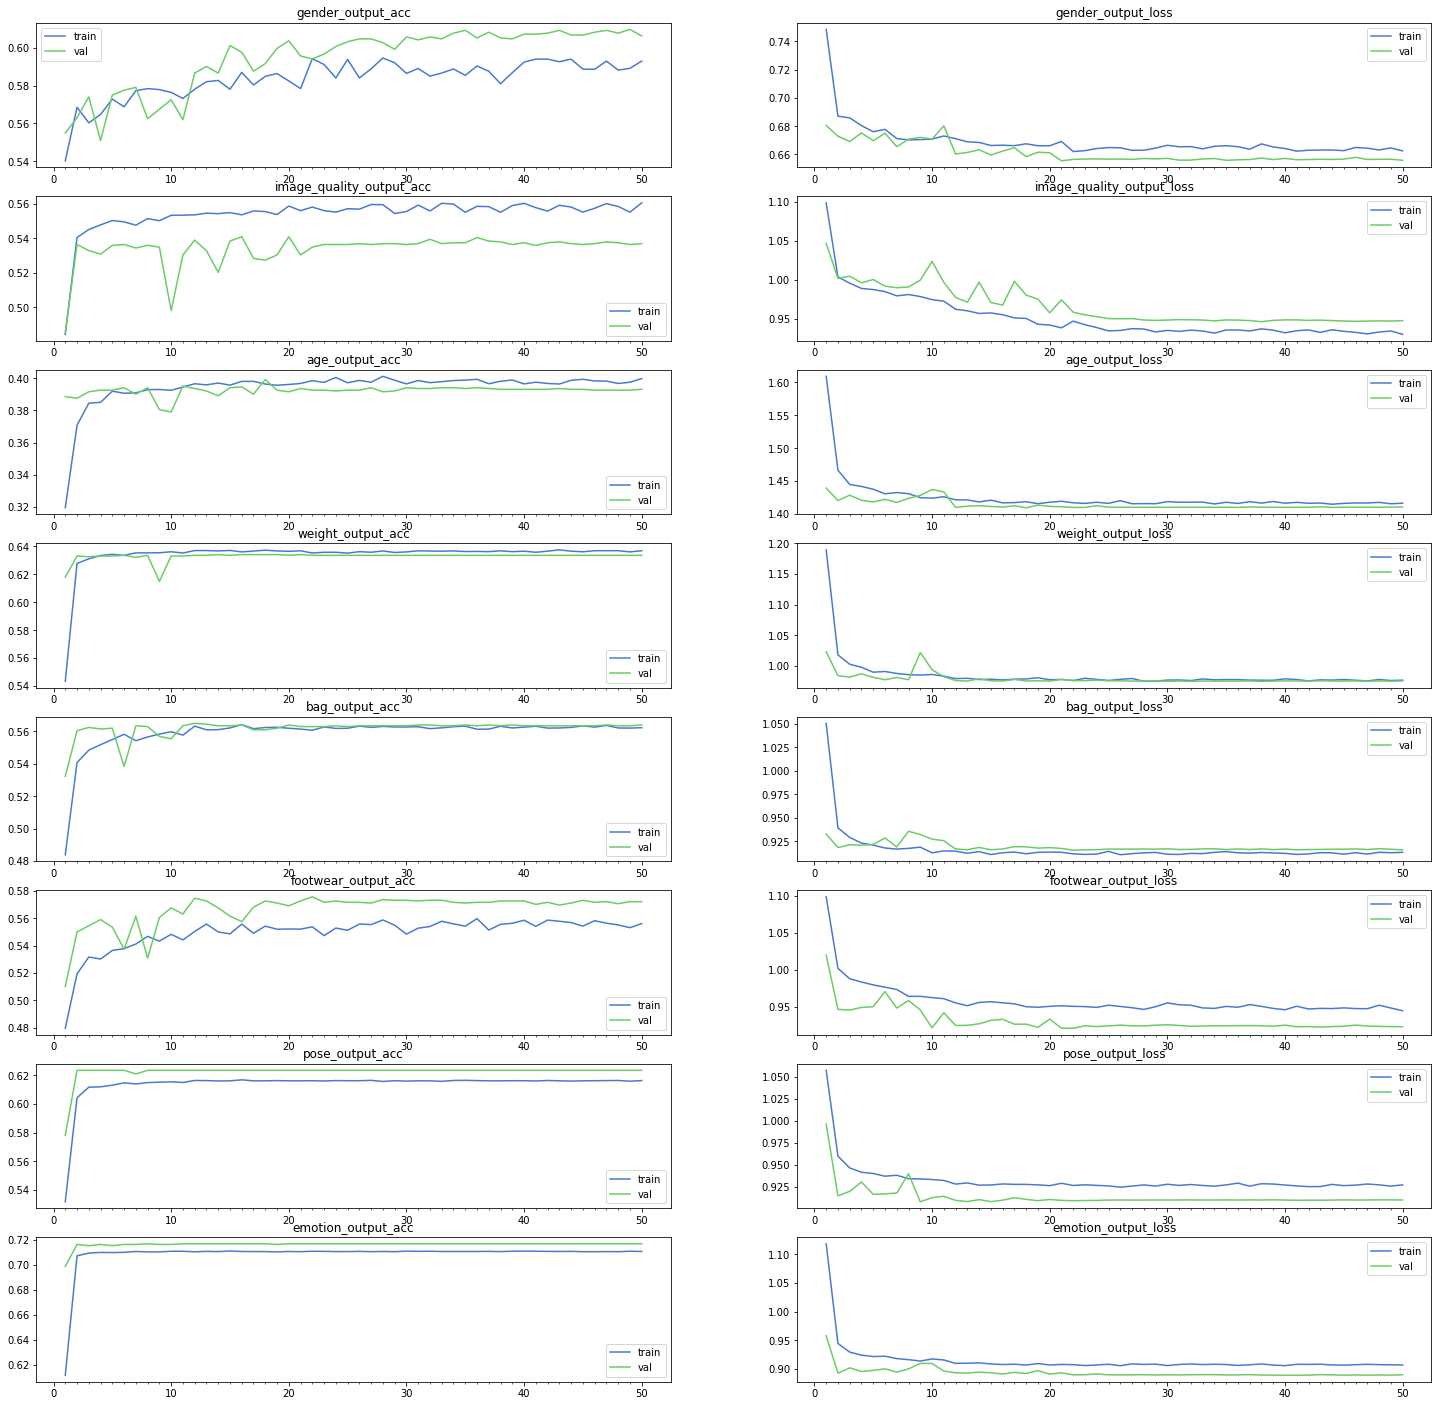

In [0]:
plot_model_history(train_history)

#### Model Summaries and Model Image

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

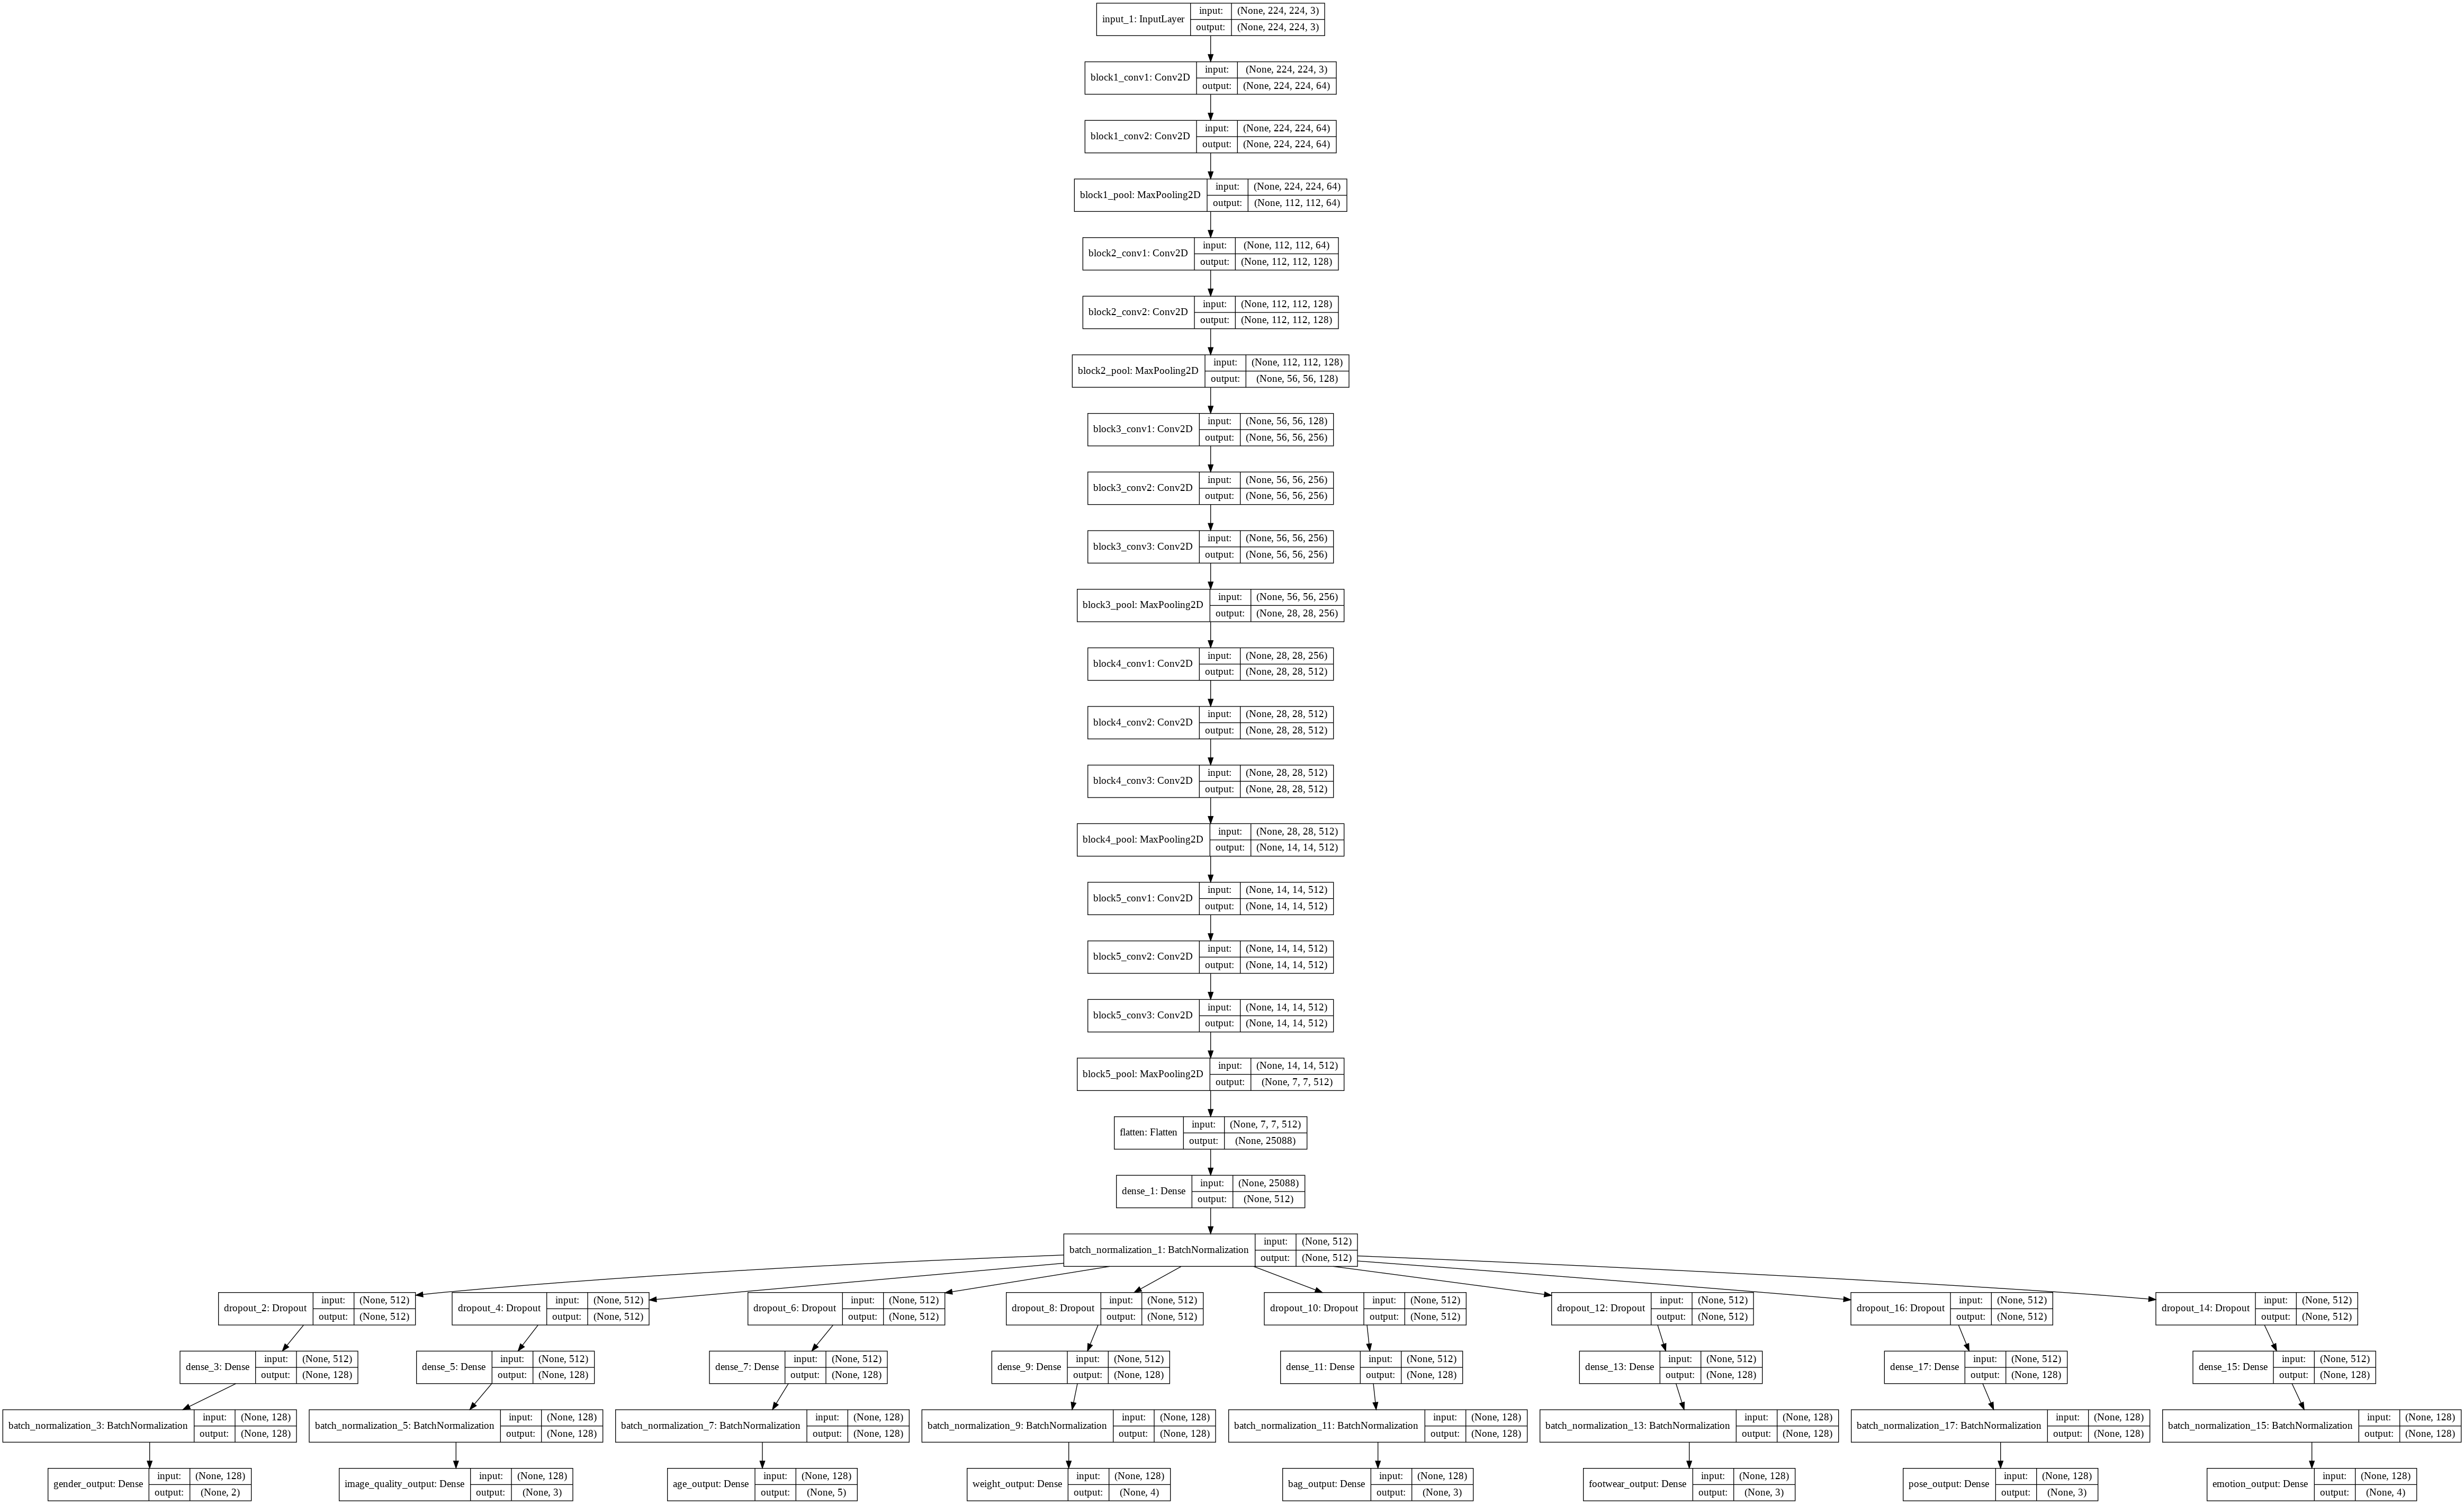

In [0]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)